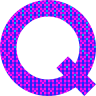
# Use a Community QLattice to solve the rain prediction in very little time

The QLattice is a supervised machine learning tool for symbolic regression developed by [Abzu](https://www.abzu.ai) . It is inspired by Richard Feynman's path integral formulation. That's why the python module to use it is called *Feyn*, and the *Q* in QLattice is for Quantum.

Abzu provides free QLattices for non-commercial use to anyone. These free community QLattices gets allocated for you automatically if you use Feyn without an active subscription, as we will do in this notebook. Read more about how it works here: https://docs.abzu.ai/docs/guides/getting_started/community.html

The feyn Python module is not installed on Kaggle by default so we have to pip install it first. 

__Note__: the pip install will fail unless you enable *Internet* in the *settings* to the right --->

In [ ]:
!pip install feyn

# Python imports
In this notebook we will use only two python modules: the `feyn` module to access the QLattice, and the `pandas` module to access the data

In [ ]:
import feyn
import pandas as pd

# Data
Read in the data and have a quick look at it:

In [ ]:
data = '/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv'
df = pd.read_csv(data)
df

# First impressions:
We notice that:
- The target variable is `RainingTomorrow`.
- All the other variables are possible predictors

## The date column
We have the `Date` of each observation. This should probably not be used as a predictor as it could lead to overfitting. However, the time of year of the observation is perhaps a good predictor. So we will create a `week` of year column to allow the model to capture seasonality.

In [ ]:
df["week"] = pd.to_datetime(df.Date).dt.isocalendar().week.astype(int)
df = df.drop("Date", axis=1)

# Data types
We observe that we have categorical (dtype `object`) and numerical columns. The QLattice will work fine with the categorical and numerical data. We just need to tell it which is which. We will create a `dict` names `stypes` with this information which we will pass to the QLattice later. Read more about categorical data in the QLattice here: https://docs.abzu.ai/docs/guides/essentials/stypes.html

In [ ]:
df.dtypes

In [ ]:
stypes = {
    "Location": "cat",
    "WindGustDir": "cat",
    "WindDir9am": "cat",
    "WindDir3pm": "cat",
    "RainToday": "cat",
    "week": "cat",
}

# Deal with missing data.
We have 145,460 observations. Let's check for missing data

In [ ]:
df.isna().sum()

# The target variable
There are over 3000 observations with no data for the target variable. We drop those observations up front

We also notice that the target variable is boolean but expressed as a string. Let us convert it to a proper boolean (0/1)

In [ ]:
df = df.dropna(subset=["RainTomorrow"])
df["RainTomorrow"]=df["RainTomorrow"]=="Yes"

# More missing data
There is a lot of missing data. Some columns just have too much to keep around: "Evaporation", "Sunshine", "Cloud9am" and "Cloud3pm". We will drop those without further ado.

In [ ]:
df = df.drop(["Evaporation", "Sunshine", "Cloud9am", "Cloud3pm"], axis=1)

In [ ]:
df.isna().sum()

# Dropping the remainder
There is still a lot of missing values. We will set aside the data with missing values (because we might use this in later extensions of this notebook where we demonstrate how to use the QLattice to impute data).

In [ ]:
na_data = df[df.isna().any(axis=1)].copy() # This dataframe holds observations where any of the values are missing
full_data = df.dropna() # This dataframe holds observations where *none* of the values are missing

# What do we have left?

We still have 112925 observations left. That should be plenty to find a good model 

In [ ]:
full_data

# Split the data in train and test.
We split the data in two equally sized buckets. We will use one set to find the model and the other to test that the model is not overfitted.

In [ ]:
train, test = feyn.tools.split(full_data, ratio=(1,1), random_state=42)

# Community QLattice
We are now ready to connect to the QLattice. The feyn module will look in you local configuration file to see if we have a commercial QLattice. If not, it will allocate a community QLattice for us on the Abzu compute cluster.

In [ ]:
ql = feyn.connect_qlattice()

# Reproducability
The qlattice will be reset when we get it, but to ensure that we get exactly the same result every time we run the notebook we need to seed the QLattice. This is done with the `reset` method

In [ ]:
ql.reset(random_seed=42)

# Search for the best model
We are now ready to instruct the QLattice to search for the best mathematical model to explain the data. Here we use the high-level convenience function that does everything with sensible defaults: https://docs.abzu.ai/docs/guides/essentials/auto_run.html. 

For more detailed control, we could use the primitives: https://docs.abzu.ai/docs/guides/primitives/using_primitives.html

Notice that the `stypes` dictionary we created earlier gets passed to the QLattice here. 

__NOTE:__ This will take several minutes to complete. It invoves work done on the QLattice machine remotely as well as in the local notebook. The part that runs locally is slowing things down because of the limited CPU resources on Kaggle. Running the same on my machine locally only takes 20 seconds!

In [ ]:
models = ql.auto_run(train, output_name="RainTomorrow", kind="classification", stypes = stypes)

# Evaluate
The QLattice has found a mathematical relationship tha can relate the predictors to the output. The final step is to evaluate the model on the test and the train set. To do that we plot the *ROC* curve of the classifier on both the test and the training data. You can read more about ROC curves here: https://docs.abzu.ai/docs/guides/plotting/roc_curve.html

In this case they overlap almost perfectly which indicates that the model generalizes to unseen data very well.

In [ ]:
models[0].plot_roc_curve(train)
models[0].plot_roc_curve(test)

# Confusion matrix
A simpler and less powerfull way to evaluate classifiers is a confusion matrix: https://docs.abzu.ai/docs/guides/plotting/confusion_matrix.html
Let us see how that looks at various thresholds

In [ ]:
models[0].plot_confusion_matrix(test, threshold=.3)

In [ ]:
models[0].plot_confusion_matrix(test, threshold=.5)

# The model is math!
What the QLattice actually finds is an equation that relates the input to the output. The user can control the compexity and structure of the equation in various ways. Here we just went with the defaults. Let's see the actual mathematical expression:

In [ ]:
models[0].sympify(2)

# Feature interaction
Finally we can see how the features interact by plotting the equation with pearson correlations of each node. See more here: https://docs.abzu.ai/docs/guides/plotting/model_plot.html


In [ ]:
models[0].plot(test)

# Conclusion
In a fex simple steps we were able to:
- Find a mathematical model that predicts rain
- Show that it gereralizes very well to new data.
- Understand which features interacts to predict rain
- Visualize the performance of the model in various ways.
